In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pathlib
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.models import ResNet18_Weights


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

#training_set = ImageFolder("Task2_dataset//training")
# data_dir = 'Task2_dataset/training'
# image_datasets = {x: datasets.ImageFolder(os.path.join(
#     data_dir, x), data_transforms[x]) for x in ['training', 'testing']}
# dataloaders = {x: torch.utils.data.DataLoader(
#     image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['training', 'testing']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
# class_names = image_datasets['training'].classes
# print(class_names)

transform = torchvision.transforms.Compose(
    [transforms.Resize((150, 150)), transforms.ToTensor()])
training_set = ImageFolder("Task2_dataset//training", transform=transform)
val_size = 120
train_size = len(training_set) - val_size
train_ds, val_ds = random_split(training_set, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, num_workers=0)
root = pathlib.Path("Task2_dataset//training")
class_names = sorted([j.name.split('/')[-1] for j in root.iterdir()])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is set to", device)
print(class_names)
print(train_loader)


Device is set to cpu
['Combat', 'DestroyedBuildings', 'Fire', 'Humanitarian Aid and rehabilitation', 'Military vehicles and weapons']


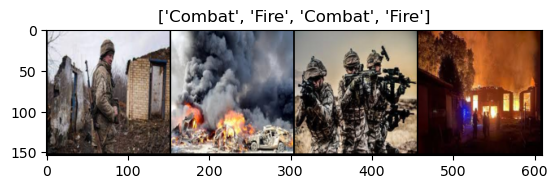

In [11]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size
            else:
                epoch_loss = running_loss / val_size
                epoch_acc = running_corrects.double() / val_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [13]:

#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()


step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)


Epoch 0/1
----------
train Loss: 1.6771 Acc: 0.4286
val Loss: 5.0979 Acc: 1.0917

Epoch 1/1
----------
train Loss: 1.3828 Acc: 0.4571
val Loss: 4.5973 Acc: 1.2333

Training complete in 1m 19s
Best val Acc: 1.233333
Epoch 0/1
----------
train Loss: 1.3725 Acc: 0.4536
val Loss: 2.0143 Acc: 1.6500

Epoch 1/1
----------
train Loss: 0.9221 Acc: 0.6607
val Loss: 1.0886 Acc: 2.1000

Training complete in 0m 35s
Best val Acc: 2.100000


In [14]:
from PIL import Image
from torch.autograd import Variable
import pandas as pd

test_data = ["building1", "building2", "combat1", "combat2",
             "fire1", "fire2", "military1", "military2", "rehab1", "rehab2"]


def prediction(transformer):
    headers = ["Acutal Image Name", "   Output Image Name"]
    data = []
    for img in test_data:
        img_path = "Task2_dataset//testing/"+img+".jpeg"
        image = Image.open(img_path)
        image_tensor = transformer(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        output = model_conv(input)
        index = output.data.numpy().argmax()
        pred = class_names[index]
        data.append([img, pred])
    print(pd.DataFrame(data, columns=headers))


transformers = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])
prediction(transformers)


  Acutal Image Name    Output Image Name
0         building1   DestroyedBuildings
1         building2   DestroyedBuildings
2           combat1   DestroyedBuildings
3           combat2                 Fire
4             fire1                 Fire
5             fire2                 Fire
6         military1                 Fire
7         military2   DestroyedBuildings
8            rehab1   DestroyedBuildings
9            rehab2   DestroyedBuildings
